# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

133073    Project CDM Coordinator  Heathrow  ****K  pack...
26174     Actuary with ALM experience required to join t...
46759     Staff Nurse, Nursing Home, Baldock White Recru...
Name: FullDescription, dtype: object

In [0]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
89638,69151684,Optical Managers Jobs in York,Flame Health Optometry Jobs Optical Manager J...,"North Yorkshire, North Yorkshire",North Yorkshire,NaN,NaN,Flame Health Associates LLP,Healthcare & Nursing Jobs,25000 - 35000 p.a.,30000,jobs.opticianonline.net,10.308986
61475,68696237,Key Stage 3 Maths Coordinator,Required April or September ****013 'WE'RE AIM...,Essex South East,UK,NaN,permanent,Hays,Teaching Jobs,"22626.00 - 37795.00 per annum + TLR 2b (4,225)",30210,totaljobs.com,10.315962
39730,68356034,Senior Account Manager,Want to work for one of the UK s leading softw...,Birmingham,Birmingham,NaN,permanent,Genesis,Sales Jobs,40000 - 50000/annum Double OTE + Benefits,45000,cv-library.co.uk,10.714440


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [0]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [0]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
data.Title.values[0]

'engineering systems analyst'

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"

for title in list(data.Title.values):
    token_counts.update(title.split(" "))
for description in list(data.FullDescription.values):
    token_counts.update(description.split(" "))

In [0]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

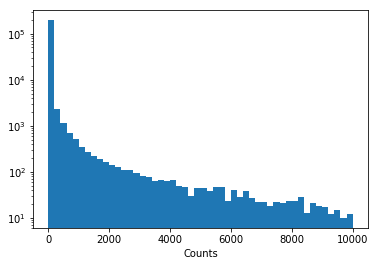

In [0]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [k for k, v in token_counts.items() if v >= min_count]   # <YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [0]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {x:idx for idx, x in enumerate(tokens)}

In [0]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [0]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [0]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  176,    48,    88,   179,   408,   179,    74,   115,  1768,
           179],
        [  165,    88,    11,   160,  2017,    11,  2592,   374,    74,
            74],
        [ 1923,    73,   561,   304,  3267,   282, 12456,   558,   944,
            73]], dtype=int32),
 'Log1pSalary': array([ 9.680407, 10.126671, 10.021315], dtype=float32),
 'Title': array([[ 176,   48,   88,  179,  408,  179,   74,  115, 1768],
        [ 165,   88,   11,  160, 2017,   11, 2592,    1,    1],
        [ 319,    1,    1,    1,    1,    1,    1,    1,    1]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h # <YOUR CODE>

In [0]:
?nn.ReLU

In [0]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# <YOUR CODE HERE>

class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h # <YOUR CODE>

In [0]:
desc_encoder = JobDescriptionEncoder(out_size = 64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobDescriptionEncoder(out_size = 64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        
        
        self.comb1_linear = nn.Linear(64+64+16, 64)
        self.relu = nn.ReLU()
        self.comb2_linear = nn.Linear(64, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix) # <YOUR CODE>
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features) # <YOUR CODE>
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.comb1_linear(joint_h)
        joint_h = self.relu(joint_h)
        joint_h = self.comb2_linear(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0] # <YOUR CODE>

In [0]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [0]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()  #[0]
        train_mae += compute_mae(reference, prediction).data.numpy()  #[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()   #[0]
        val_mae += compute_mae(reference, prediction).data.numpy()   #[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:



	Loss:	12.02109
	MAE:	33980.22006



Validation:



	Loss:	0.74314
	MAE:	10200.19051



Training:



	Loss:	0.59607
	MAE:	7411.49638



Validation:



	Loss:	0.48484
	MAE:	6739.79171



Training:



	Loss:	0.40724
	MAE:	5885.68369



Validation:



	Loss:	0.35393
	MAE:	5256.74664



Training:



	Loss:	0.33902
	MAE:	5409.07961



Validation:



	Loss:	0.30454
	MAE:	5356.28846



Training:



	Loss:	0.27787
	MAE:	4867.92413



Validation:



	Loss:	0.27345
	MAE:	5116.30870



Training:



	Loss:	0.25178
	MAE:	4697.14097



Validation:



	Loss:	0.24169
	MAE:	4681.09924



Training:



	Loss:	0.23392
	MAE:	4501.50874



Validation:



	Loss:	0.22004
	MAE:	4153.03685



Training:



	Loss:	0.22394
	MAE:	4354.53155



Validation:



	Loss:	0.20389
	MAE:	4254.90645



Training:



	Loss:	0.20410
	MAE:	4165.70685



Validation:



	Loss:	0.23024
	MAE:	4094.43706



Training:



	Loss:	0.18813
	MAE:	4075.72670



Validation:



	Loss:	0.19335
	MAE:	3849.15147



Training:



	Loss:	0.16433
	MAE:	3760.33744



Validation:



	Loss:	0.17457
	MAE:	3777.23513



Training:



	Loss:	0.18039
	MAE:	3979.32412



Validation:



	Loss:	0.16898
	MAE:	3994.70105



Training:



	Loss:	0.16589
	MAE:	3869.79098



Validation:



	Loss:	0.15725
	MAE:	3634.59356



Training:



	Loss:	0.15819
	MAE:	3692.61470



Validation:



	Loss:	0.15258
	MAE:	3583.48948



Training:



	Loss:	0.14295
	MAE:	3663.09499



Validation:



	Loss:	0.14417
	MAE:	3506.42922



Training:



	Loss:	0.16156
	MAE:	3779.26887



Validation:



	Loss:	0.13984
	MAE:	3507.42094



Training:



	Loss:	0.14074
	MAE:	3428.53424



Validation:



	Loss:	0.13554
	MAE:	3415.44983



Training:



	Loss:	0.14441
	MAE:	3666.39463



Validation:



	Loss:	0.13600
	MAE:	3517.00771



Training:



	Loss:	0.14518
	MAE:	3567.13390



Validation:



	Loss:	0.14326
	MAE:	3779.58689



Training:



	Loss:	0.13386
	MAE:	3480.48893



Validation:



	Loss:	0.14449
	MAE:	3823.35990



Training:



	Loss:	0.12879
	MAE:	3351.52459



Validation:



	Loss:	0.13384
	MAE:	3603.60100



Training:



	Loss:	0.13151
	MAE:	3497.30229



Validation:



	Loss:	0.14202
	MAE:	3806.82332



Training:



	Loss:	0.11586
	MAE:	3271.52133



Validation:



	Loss:	0.13010
	MAE:	3307.89411



Training:



	Loss:	0.13709
	MAE:	3550.63303



Validation:



	Loss:	0.12401
	MAE:	3244.11515



Training:



	Loss:	0.12220
	MAE:	3297.03550



Validation:



	Loss:	0.12516
	MAE:	3423.67726



Training:



	Loss:	0.11466
	MAE:	3174.56768



Validation:



	Loss:	0.11968
	MAE:	3192.52864



Training:



	Loss:	0.12452
	MAE:	3431.47907



Validation:



	Loss:	0.12025
	MAE:	3343.15425



Training:



	Loss:	0.11359
	MAE:	3268.06243



Validation:



	Loss:	0.11375
	MAE:	3125.04630



Training:



	Loss:	0.11745
	MAE:	3360.49296



Validation:



	Loss:	0.11218
	MAE:	3204.56008



Training:



	Loss:	0.11142
	MAE:	3170.82291



Validation:



	Loss:	0.11842
	MAE:	3408.17779



Training:



	Loss:	0.11247
	MAE:	3202.37864



Validation:



	Loss:	0.15341
	MAE:	4218.98137



Training:



	Loss:	0.10719
	MAE:	3231.23028



Validation:



	Loss:	0.12962
	MAE:	3667.23515



Training:



	Loss:	0.10667
	MAE:	3151.18660



Validation:



	Loss:	0.10395
	MAE:	3001.14934



Training:



	Loss:	0.10880
	MAE:	3219.77507



Validation:



	Loss:	0.10382
	MAE:	3050.29442



Training:



	Loss:	0.10390
	MAE:	3082.68152



Validation:



	Loss:	0.10624
	MAE:	3047.49073



Training:



	Loss:	0.11096
	MAE:	3213.92598



Validation:



	Loss:	0.10219
	MAE:	2985.20661



Training:



	Loss:	0.11053
	MAE:	3124.25773



Validation:



	Loss:	0.10491
	MAE:	3121.04802



Training:



	Loss:	0.10189
	MAE:	3012.98323



Validation:



	Loss:	0.10330
	MAE:	3111.94190



Training:



	Loss:	0.10133
	MAE:	3111.34998



Validation:



	Loss:	0.10217
	MAE:	3063.55507



Training:



	Loss:	0.09790
	MAE:	3070.17232



Validation:



	Loss:	0.10608
	MAE:	3013.06489





In [0]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.09870
	MAE:	3018.01496





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    sample = pd.DataFrame(sample).T
    batch = generate_batch(sample)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    
    baseline_pred = model(title_ix, desc_ix, cat_features).detach().numpy()[0]
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    
    tokens = str(sample[col_name].values[0]).split()
    for i in range(len(tokens)):
        sample_without_word = pd.DataFrame(sample.copy())
        tokens_without_word = tokens.copy()
        tokens_without_word[i] = UNK
        sample_without_word[col_name].values[0] = ' '.join(tokens_without_word)
        batch_without_word = generate_batch(sample_without_word)
        title_ix_without_word = torch.tensor(batch_without_word["Title"], dtype=torch.int64)
        desc_ix_without_word = torch.tensor(batch_without_word["FullDescription"], dtype=torch.int64)
        cat_features_without_word = torch.tensor(batch_without_word["Categorical"], dtype=torch.float32)

        predictions_without_word.append(model(title_ix_without_word, desc_ix_without_word, cat_features_without_word).detach().numpy()[0])


    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return list(zip(tokens, score_differences)) #<YOUR CODE>

In [0]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, col_name = "Title")
print(tokens_and_weights)

Input: Id                                                             70766223
Title                 project assistant / administrator business events
FullDescription       project assistant / administrator business eve...
LocationRaw                           Camden, North London (N1), London
LocationNormalized                                         North London
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                       RecruitmentRevolution.com
Category                                                     Admin Jobs
SalaryRaw                                           18000 - 19000/annum
SalaryNormalized                                                  18500
SourceName                                             cv-library.co.uk
Log1pSalary                                                     9.82558
Name: 150601, dtype: object
[('project', -0.10945988), ('

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [0]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
batch = generate_batch(pd.DataFrame(sample).T)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
print("Salary (gbp):", model(title_ix, desc_ix, cat_features).detach().numpy()[0])  # <YOUR CODE>

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 134131
Salary (gbp): 9.772742


customer support manager bournemouth , dorset

tribepost ltd are working on behalf of our client to fill this vacancy . available vacancy : customer support manager this position is based in : bournemouth , dorset employment status : permanent salary : **** **** bonus benefits a leading software vendor is recruiting for a customer support manager to join their team in bournemouth . you will be responsible for managing the customer support team in ensuring the customers ’ are provided with exceptional customer service and resolving the customer support issues . you will be pivotal in driving forward the product development in collaboration with internal departments to ensure the quality and consistency of the product is of the highest standard . as customer support manager you will lead , support , coach , train and develop the team to ensure they provide excellent customer support and ensure as individuals they are reaching their full potential through leading by example . to perform the duties of this role you will have proven management experience within a support department working for a software vendor . you will have proven experience of responding to and managing conflicting priorities whilst continuously focusing on serving all customers and users to the highest professional standards . this vacancy is being advertised by tribepost ltd . the services advertised by tribepost ltd are those of an employment agency . this vacancy would be of interest to job seekers searching for the following vacancies : customer support manager . this job was originally posted as www . totaljobs . com / jobseeking / customersupportmanagerbournemouthdorset_job ****

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

------------------------------------------------

### 1. Optimizing seriously

In [0]:
from IPython.display import clear_output

def train_with_early_stopping(model,
                             num_rounds = 4,
                             num_epochs = 100,
                             max_len = 100,
                             batch_size = 32,
                             batches_per_epoch = 100):
  
  min_val_loss = 1e6
  min_val_mae = 1e6
  rounds_passed = 0
  train_losses = []
  train_mae_list = []
  val_losses = []
  val_mae_list = []
  
  
  for epoch_i in range(num_epochs):
    
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()  #[0]
        train_mae += compute_mae(reference, prediction).data.numpy()  #[0]
        train_batches += 1
        
    train_losses.append(train_loss / train_batches)
    train_mae_list.append(train_mae / train_batches)
    
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False, verbose=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()   #[0]
        val_mae += compute_mae(reference, prediction).data.numpy()   #[0]
        val_batches += 1
        
    val_losses.append(val_loss / val_batches)
    val_mae_list.append(val_mae / val_batches)
        
    
    clear_output()
    fig, ax = plt.subplots(figsize = (20, 6), ncols= 2, nrows = 1)
    ax[0].plot(train_losses, label = 'Train loss', color = 'blue')
    ax[0].plot(val_losses, label = 'Val loss', color = 'orange')
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    
    ax[1].plot(train_mae_list, label = 'Train MAE', color = 'blue')
    ax[1].plot(val_mae_list, label = 'Val MAE', color = 'orange')
    ax[1].legend()
    ax[1].set_ylabel('MAE')
    
    plt.show()
    
    
    if val_loss / val_batches < min_val_loss:
      
        rounds_passed = 0
        min_val_loss = val_loss / val_batches
        min_val_mae = val_mae / val_batches
        best_model = model.state_dict()
    else:
        rounds_passed += 1
        
    if rounds_passed == num_rounds:
        print('Early stopping at epoch № {}'.format(epoch_i))
        print('Best val loss: %.5f' % min_val_loss)
        print('Best val mae: %.5f' % min_val_mae)
        return best_model
        break
        
  return best_model

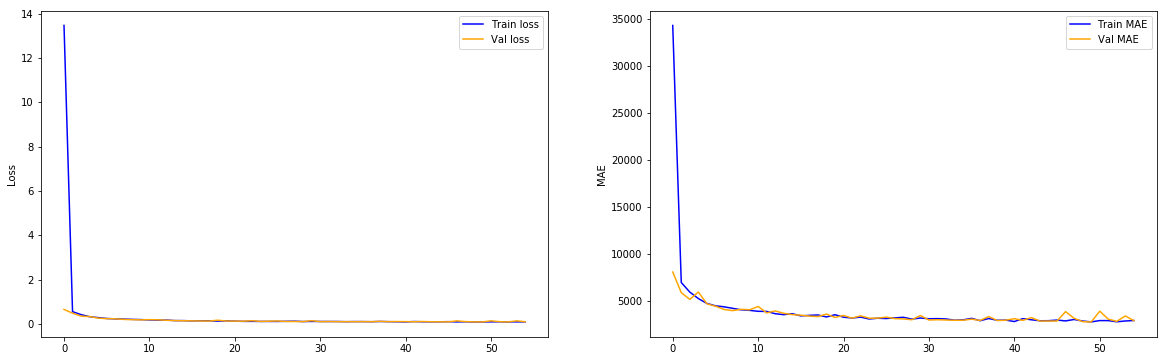

Early stopping at epoch № 54
Best val loss: 0.08900
Best val mae: 2806.60415


In [0]:
model_stopping_rounds = FullNetwork()
opt = torch.optim.Adam(model_stopping_rounds.parameters(), lr=1e-3)
best_model = train_with_early_stopping(model = model_stopping_rounds,
                                        num_rounds = 5,
                                        num_epochs = 100)

### 2. CNN architecture

I will try to add some more layers, batchnorms, dropout

In [0]:
class FullNetwork_advanced(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobDescriptionEncoder(out_size = 64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        
        self.final_layers = nn.Sequential(
          nn.Linear(64+64+16, 64),
          nn.BatchNorm1d(num_features = 64),
          nn.Dropout(0.2),
          nn.Linear(64, 16),
          nn.BatchNorm1d(num_features = 16),
          nn.Linear(16, 1)
        )
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix) # <YOUR CODE>
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features) # <YOUR CODE>
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.final_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0] # <YOUR CODE>

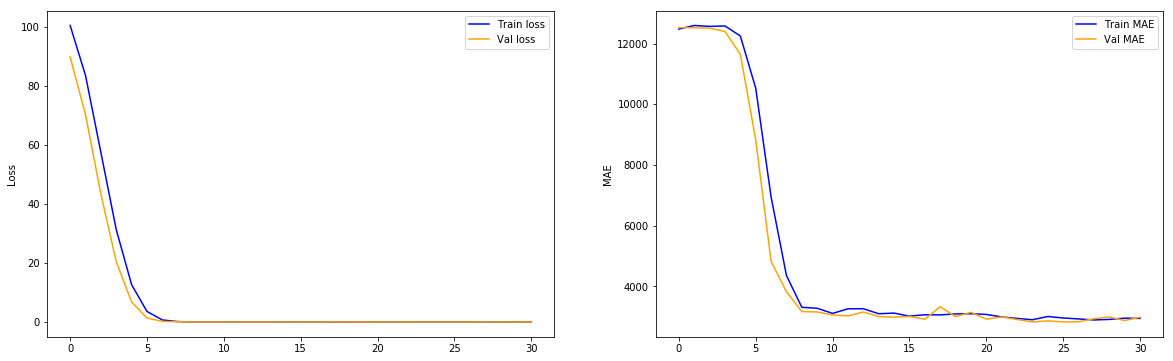

Early stopping at epoch № 30
Best val loss: 0.08751
Best val mae: 2831.13878


In [0]:
model_stopping_rounds_adv = FullNetwork_advanced()
opt = torch.optim.Adam(model_stopping_rounds_adv.parameters(), 
                       lr=1e-3, 
                       weight_decay = 1e-3)

train_with_early_stopping(model = model_stopping_rounds_adv,
                          num_rounds = 5,
                          num_epochs = 100)

Continue training the same neural network (saved from early stopping) with x100 smaller learning rate

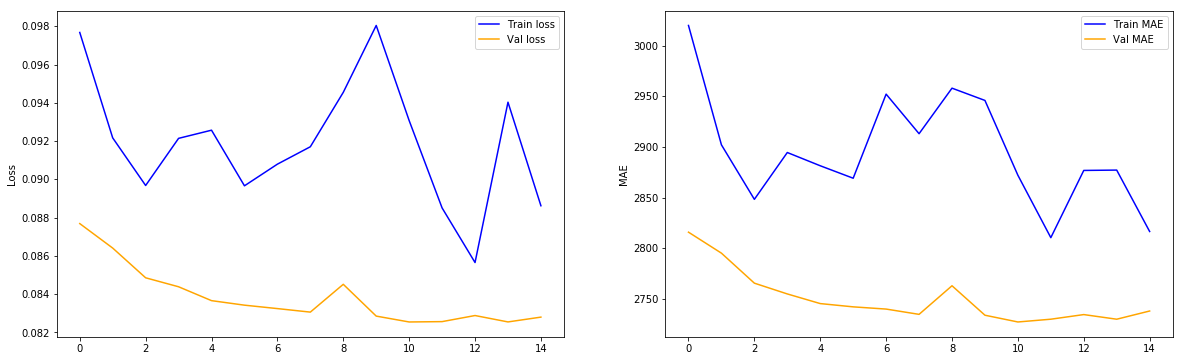

Early stopping at epoch № 14
Best val loss: 0.08255
Best val mae: 2727.21745


In [0]:
opt = torch.optim.Adam(best_model.parameters(), 
                       lr=1e-5, 
                       weight_decay = 1e-3)

best_model = train_with_early_stopping(model = best_model,
                                        num_rounds = 4,
                                        num_epochs = 20)

### 3. Play with pooling

In [0]:
class SoftMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        softmax = x.exp() / (x.exp().sum(-1)).unsqueeze(-1)
        softmaxpool = x * softmax   # element-wise multiplication
        return softmaxpool.sum(dim=self.dim)
      
      
# class AttentionPooling(nn.Module):
#     def __init__(self, dim=-1, n_features, n_outputs):
#         super(self.__class__, self).__init__()
#         self.dim = dim
#         self.n_features = n_features 
#         self.attention_linear = nn.Linear(n_features, n_outputs)
        
#     def forward(self, x):
        
#         x = self.attention_linear(x)
#         softmax = x.exp() / x.exp().sum(dim = 0)
#         softmaxpool = x @ softmax
#         return softmaxpool.sum(dim=self.dim)
      
      
class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> soft_max pool -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool11 = SoftMaxPooling()  # SoftMax pooling !!! 
        self.pool12 = GlobalMaxPooling()  # GlobalMax pooling !!! 
        self.dense = nn.Linear(2*out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        
        h = self.conv1(h)
        h1 = self.pool11(h)
        h2 = self.pool12(h)
        h = torch.cat([h1, h2], dim=1) # concat pooling
        h = self.relu(h)
        h = self.dense(h)
        
        return h # <YOUR CODE>
      
      
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> soft_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool11 = SoftMaxPooling()  # SoftMax pooling !!! 
        self.pool12 = GlobalMaxPooling()  # GlobalMax pooling !!! 
        self.dense = nn.Linear(2*out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        
        h = self.conv1(h)
        h1 = self.pool11(h)
        h2 = self.pool12(h)
        h = torch.cat([h1, h2], dim=1)  # concat pooling
        h = self.relu(h)
        h = self.dense(h)
        
        return h # <YOUR CODE>

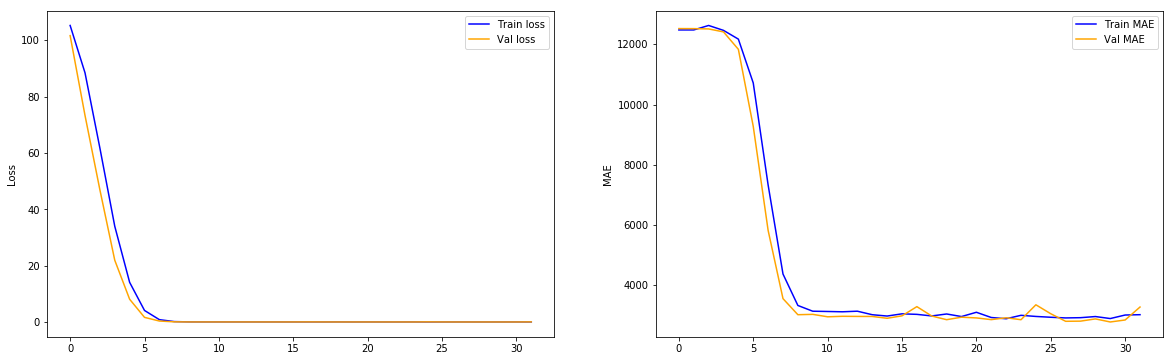

Early stopping at epoch № 31
Best val loss: 0.08571
Best val mae: 2806.80794


In [0]:
model_stopping_rounds_pool = FullNetwork_advanced()
opt = torch.optim.Adam(model_stopping_rounds_pool.parameters(), 
                       lr=1e-3, 
                       weight_decay = 1e-3)

best_model = train_with_early_stopping(model = model_stopping_rounds_pool,
                                        num_rounds = 5,
                                        num_epochs = 100)

Continue training with x100 smaller learning rate

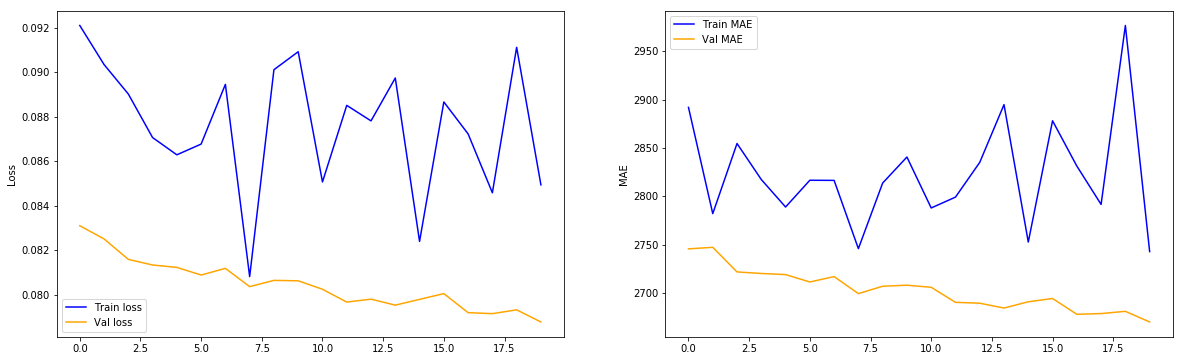

In [0]:
opt = torch.optim.Adam(model_stopping_rounds_pool.parameters(), 
                       lr=1e-5, 
                       weight_decay = 1e-3)

best_model = train_with_early_stopping(model = model_stopping_rounds_pool,
                                        num_rounds = 4,
                                        num_epochs = 20)

Loss decays => continue training

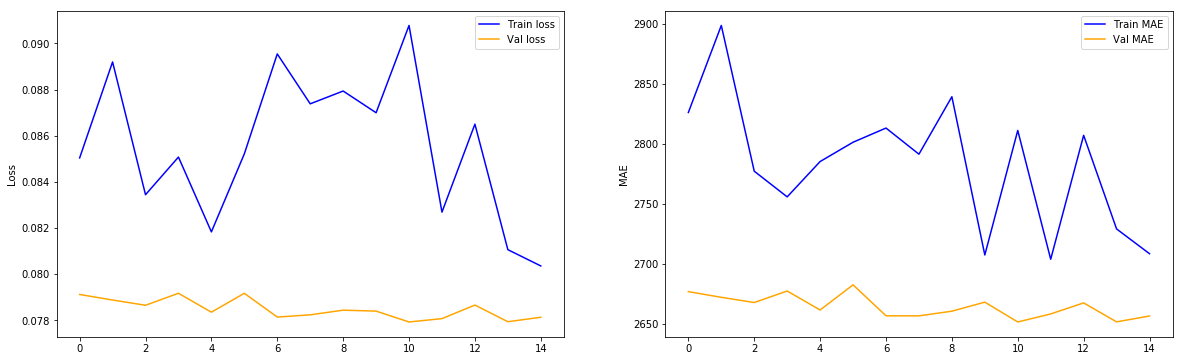

Early stopping at epoch № 14
Best val loss: 0.07793
Best val mae: 2651.47336


In [0]:
opt = torch.optim.Adam(model_stopping_rounds_pool.parameters(), 
                       lr=1e-5, 
                       weight_decay = 1e-3)

best_model = train_with_early_stopping(model = model_stopping_rounds_pool,
                                        num_rounds = 4,
                                        num_epochs = 20)

### A short report


_Before any advanced methods Val MAE ~ 3018_

1. **Early stopping**    
- Early stopping yielded much better validation MAE. Moreover, training stopped at 54th epoch which is almost x2 times faster than training 100 epoch
- After early stopping I continue learning the best saved neural network with x100 lower learning rate for additional 20 epochs. Of course, I use early stopping here too:). It gives additional improvement in val MAE ~ 5%

_At the end Val MAE ~ 2800_

2. **CNN architecture**  
- Batchnorm   
Slightly smoother loss convergence
- Dropout  
helped a bit in terms of val MAE
- Weight_decay  
helped a bit in terms of val MAE and smoothness of convergence
- More layers   
a bit better val MAE

_At the end Val MAE ~ 2720_

3. **Play with pooling**
- softmax pooling  
The same as GlobalMaxPooling
- Let's use Global max pooling, Softmax pooling and concat them all!  
It worked pretty well, yileded better MAE

_At the end Val MAE ~ 2650_
